# Control in small state-action spaces
- Introduction to Gymnasium
- Seeing Cliff walking as an instance of discounted MDP
- Bellman operators, Greedyfication
- Value iteration for state value function
- Modified policy iteration for state value function
- Policy iteration for state value function
- Modified policy iteration for action-state value function
- Policy iteration for action-state value function

In [5]:
# To run cells, push MAJ-ENTER or click on the play button at the left of the cells
# Please turn-off AI: from the Tools menu, select Settings, followed by AI assistance. In that space, you'll be able to revoke consent and hide AI coding features.

In [6]:
# Install depencies
!pip install rlclass

In [39]:
import rlclass
from rlclass.utils import make_animation
import numpy as np
import matplotlib.pyplot as plt

# Gymnasium


Gymnasium is a project that provides an interface for single agent reinforcement learning environments. We will see how to use it in this practical session. You might also want to look at the [official documentation](https://gymnasium.farama.org/introduction/basic_usage/)

In [8]:
# Let us first install gymnasium
!pip install swig gymnasium matplotlib

In [9]:
# Many environment are available
# For our purpose, an environment is a markov decision process (MDP)
# Note: they are environment in gymnasium that are not MDPs but we will not consider these in this class
import gymnasium
gymnasium.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [10]:
# We will work with the Cliff Walking environment

# Initialize the environment
env = gymnasium.make('CliffWalking-v0', render_mode="rgb_array")

# Each environment has an action space and a state space
actions = env.action_space
states = env.observation_space

# There is 4 actions: up, left, right, down
print(actions)
# Discrete(4) means the available actions are 0, 1, 2, 3

# There are 48 states (one for each cell in the grid)
print(states)
# Discrete(48) means the available states are 0, 1,..., 47

# render_mode = "rgb_array" means env.render() will return an rgb image

Discrete(4)
Discrete(48)


In [11]:
# In the CliffWalking environment, the number of states and number of actions is finite.
# They can be accessed via
print(env.observation_space.n, env.action_space.n)

48 4


36


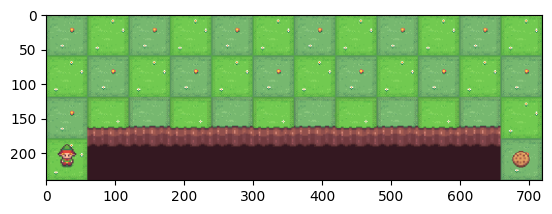

In [12]:
# Let us start a new game
s0, _ = env.reset()

# s0 is the initial state (it has a value between 0 and 47)
print(s0)

# Render the game: env.render() returns a matrix of pixels that forms an image
img = env.render()

# We can plot it using matplotlib
import matplotlib.pyplot as plt
plt.imshow(env.render())

# Cliff walking
The goal of the game is to move the pixie to the cookie while avoiding the cliff. The person can either move up, left, right, down. Whatever move gives a reward of -1 except if the move makes the pixie fall from the cliff which gives a reward of -100 and puts the pixie back at its starting position. The game ends when the cookie is found.

-1
24
False
False
(240, 720, 3)


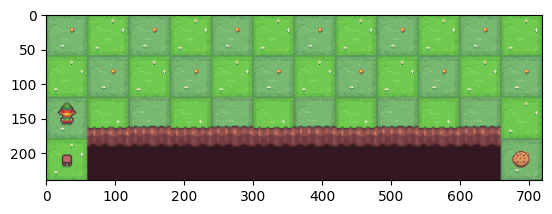

In [13]:
# In order to play an action you use env.step

# Let us play action 0
next_state, reward, terminated, truncated, info = env.step(0)

# It gives us a reward of -1
print(reward)

# We can see at which state we land
print(next_state)

# And whether the game was terminated because we got the cookie
print(terminated)

# Or if the game was terminated because the maximum number of moves were done
print(truncated)

# Let us plot where we are now
plt.imshow(env.render())
print(env.render().shape)

# Transition matrix and reward functions
The transition matrix $P$ is such that
$P_{a}(s, s')$ gives the probability to transition to state $s'$ from state $s$ after action $a$ is taken. The reward function $r$ is such that $r_a(s)$ is the reward obtained after taking action $a$ in state $s$.

The transition matrix and reward function can be obtained by calling `env.unwrapped.P`
 where `env.unwrapped.P[state][action]` gives you a list of elements each of the form (transition probability, next state, reward, Is terminal state?).
 Each element in the list therefore gives you the probability to end in
some state, the associated reward and whether it is a terminal state.

In [14]:
# Here it is a deterministic environment so we have only one element in the list
print(env.unwrapped.P[32][1]) # returns [((transition probability, next state, reward, Is terminal state?))]

[(1.0, np.int64(33), -1, False)]


It would be nice if we could display an animation to track our moves.
The function `make_animation` takes as input a list of images (such as the ones generated from `env.render()`) and make an animation from it to display in the notebook.

In [15]:
s0, _ = env.reset()
imgs = []
for _ in range(10):
  a = env.action_space.sample()
  env.step(a)
  imgs.append(env.render())
make_animation(imgs)

**Task** Play a bit with the environment to make sure you understand how it works. Can you find "by hand" the sequence of action that leads to the highest reward ?

In [16]:
s0, _ = env.reset()
optimal_policy = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
imgs = []
for action in optimal_policy:
  next_state, reward, terminated, truncated, info = env.step(action)
  #env.step(action)
  imgs.append(env.render())
make_animation(imgs)

In [17]:
print(terminated)
print(reward)

True
-1


# Value iteration via Bellman optimality operator
**Question:** In class, the criterion we were trying to maximize was
$$
V(s_0) = \mathbb{E}[\sum_{t=0}^\infty \gamma^t r_{a_t}(s_t)].
$$
so we use an infinite horizon and a discount. However in the cliff walking game, the horizon is finite (but depends on previous actions) and we want to maximize the sum of reward. Can we cast the cliff walking game in the framework we have seen, so that optimizing with the discounted objective gives the optimal policy ?

Il suffit de faire en sorte que l'agent reste sur le cookie ensuite. Lorsqu'on touche le cookie il faut gagner un reward positif ou nul.

**Task:** From `env.unwrapped.P` build the reward function and the transition matrix *be careful about what to do with actions that terminates the game*

In [18]:
env.unwrapped.P[1][1][0]

(1.0, np.int64(2), -1, False)

In [19]:
def make_reward_function_transition_matrix(env):
  """
  Build reward function and transition function

  Parameters
  ----------
  env: Environment

  Return
  -------
  reward: np array of shape (n_actions, n_states)
   reward[a, s] return the reward obtained after playing action a in state s
  transition: np array of shape (n_actions, n_states, n_states)
   transition[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  """
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  reward = np.array(np.zeros((n_actions, n_states)))
  transition = np.array(np.zeros((n_actions, n_states, n_states)))
  for state in range(n_states):
    for action in range(n_actions):
      transition_probability, next_state, r, terminated = env.unwrapped.P[state][action][0]
      if not terminated:
        reward[action, state] = r
        transition[action, state, next_state] = transition_probability
      else:
        reward[action, state] = 1000
        transition[action, state, state] = 1
  return reward, transition

In class we have seen the value iteration algorithm that works by starting from the value function $v = 0$ and iterates
$$
v_{k+1} = T v_k
$$
where
$$
T(v)(s) = \max_a (r_a(s) + \gamma \sum_{s'} P_a(s, s') v(s')).
$$
After $K$ iterations we return the policy greedy with respect to $v_K$:
$$
\pi(s) = \text{argmax}_a \left(r_a(s) + \gamma \sum_{s'} P_a(s, s') v_K(s')\right).
$$

**Task** Implement the bellman optimality operator for value functions

In [20]:
def T(v, R, P, gamma):
  """
  Implement the bellman optimality operator for value functions
  Parameters
  ----------
  v: np array of size n_states
    Value function
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  gamma: float
    Discounting parameter (between 0 and 1)
  Return
  ------
  Tv: np array of size n_states
    Improved value function
  """
  Tv = np.zeros(len(v))
  for s in range(len(v)):
    Tv[s] = np.max(R[:, s] + gamma * np.dot(P[:, s, :], v))
  return Tv

**Task** Implement a policy that is greedy with respect to a value function

In [21]:
def greedy_policy_value(v, R, P, gamma):
  """
  Implement the greedy policy with respect to a value function

  Parameters
  ----------
  v: np array of size n_states
    value function
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  gamma: float
    Discounting parameter (between 0 and 1)
  Return
  ------
  pi: np array of size n_states
    greedy policy pi[s] return the action to play in state s
  """
  pi = np.zeros(len(v))
  for s in range(len(v)):
    pi[s] = np.argmax(R[:, s] + gamma * np.dot(P[:, s, :], v))
  return pi

**Task** Implement value iteration for value function by iterating the bellman optimality operator

In [22]:
def VI(R, P, n_iter, gamma):
  """
  Implement value iteration for value function:
  - Initialize value function v to zero
  - Apply n_iter times the bellman optimality operator to v
  - Return the resulting v and the Greedy policy with respect to it

  Parameters
  ----------
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  n_iter: int
   Number of times the optimality operator is applied before greedification
  gamma: float
    Discounting parameter (between 0 and 1)

  Return
  ------
  pi: np array of size n_states
    Policy returned by the algorithm
  v: np array of size n_states
    Value function returned by the algorithm
  """
  v = np.zeros(len(R[0]))
  for _ in range(n_iter):
    v = T(v, R, P, gamma)
  pi = greedy_policy_value(v, R, P, gamma)
  return pi, v

Let's test above implementation empirically by looking at the agent behavior for `n_iter=100`.

In [23]:
s, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
pi, v = VI(R, P, 100, 0.9)
total_reward = 0
imgs = [env.render()]

for _ in range(100):
  a = pi[s]
  s, r, term, trunc, _ = env.step(int(a))
  total_reward += r # let us keep count of the reward we gain
  imgs.append(env.render())
  # When the game terminates we stop
  if term:
    break
print("Sum of rewards", total_reward)
make_animation(imgs)

Sum of rewards -13


# An equivalent view of Value iteration via Bellman policy evaluation operator

To compute $v_{\pi}$, the value function of a policy $\pi$ we can iterate
$v_{k+1} = T^{\pi} v_k$
where $T^{\pi}$ is the policy evaluation operator defined by:
$$
T^{\pi} v (s) = \sum_a \pi(a | s) r_a(s) + \pi(a | s) \sum_{s'} P_a(s, s') v(s').
$$

We can see one iteration of value iteration $v_{k+1} = T v_{k}$ as:
- Set $\pi_k$ to be the greedy policy with respect to $v_k$ (**policy improvement** or **greedifying**)
- Set $v_{k+1} = T^{\pi_k} v_k$  (**policy evaluation**)

VI performs the iterations above $K$ times starting from $v_0 = 0$ and returns $\pi_{K+1}$.

**Task** Implement the Bellman policy evaluation operator $T^{\pi}$ for value functions

In [32]:
def Tpi(v, pi, R, P, gamma):
  """
  Implement the bellman policy evaluation operator for value functions
  Parameters
  ----------
  v: np array of size n_states
    Value function
  pi: np array of size n_states
    Deterministic policy
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  gamma: float
    Discounting parameter (between 0 and 1)
  Return
  ------
  Tpiv: np array of size n_states
    Improved value function
  """
  n_states = len(v)
  Tpiv = np.zeros(n_states)
  for s in range(len(v)):
    a = int(pi[s])
    Tpiv[s] = R[a, s] + gamma * P[a, s, :].dot(v)  # pi(a|s) vaut 1 ou 0
  return Tpiv

**Task** Implement value iteration for value function by using the policy evaluation operator and greedifying

In [36]:
def VI2(R, P, n_iter, gamma):
  """
  Implement value iteration for value function by
  initializing the value function v to zero and repeating
  n_iter times:
    - Compute the greedy policy pi with respect to v
    - Apply the policy evaluation operator to pi

  Parameters
  ----------
  v: np array of size n_states
    value function
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  n_iter: int
   Number of iterations in the main loop
  gamma: float
    Discounting parameter (between 0 and 1)

  Return
  ------
  pi: np array of size n_states
    Policy returned by the algorithm
  v: np array of size n_states
    Value function returned by the algorithm
  """
  n_actions, n_states = R.shape
  v = np.zeros(n_states)
  for _ in range(n_iter):
    pi = greedy_policy_value(v, R, P, gamma)
    v = Tpi(v, pi, R, P, gamma)
  return greedy_policy_value(v, R, P, gamma), v

In [37]:
s, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
pi, v = VI2(R, P, 100, 0.9)
total_reward = 0
imgs = [env.render()]

for _ in range(100):
  a = pi[s]
  s, r, term, trunc, _ = env.step(int(a))
  total_reward += r # let us keep count of the reward we gain
  imgs.append(env.render())
  # When the game terminates we stop
  if term:
    break
print("Sum of rewards", total_reward)
make_animation(imgs)

Sum of rewards -13


**Task** Check that the two implementations of VI are identical

In [38]:
#@title Solution
s0, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
pi, v = VI(R, P, 5, 0.9)
pi2, v2 = VI2(R, P, 5, 0.9)
for s in range(len(v)):
  np.testing.assert_equal(pi[s], pi2[s])
  np.testing.assert_equal(v[s], v2[s])

# Modified policy iteration (MPI)
Modified policy iteration starts from $v_0 = 0$ and iterates:
- Set $\pi_k$ to be the greedy policy with respect to $v_k$ (**policy improvement** or **greedifying**)
- Set $v_{k+1} = (T^{\pi_k})^{m} v_k$  ($m \geq 1$ iterations of the **policy evaluation** operator)

Modified PI performs the iterations above $K$ times starting from $v_0 = 0$ and returns $\pi_{K+1}$.

If we set $m=1$, we recover value iteration.

**Task** Implement modified policy iteration for value function.

In [40]:
def Modified_PI(R, P, n_iter, n_evaluations, gamma, v_true=None):
  """
  Implement value iteration for value function by
  initializing the value function v to zero and repeating
  n_iter times:
    - Return the greedy policy pi with respect to v
    - Apply the policy evaluation operator n_evaluations time to pi
  Record the l infinity norm between v and v_true after policy evaluation step

  Parameters
  ----------
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  n_iter: int
   Number of iterations in the main loop
  n_evaluations: int
   Number of times the policy evaluation operator is applied per iteration
  gamma: float
    Discounting parameter (between 0 and 1)
  v_true: np array of size n_states or None
   The true value function

  Return
  ------
  pi: np array of size n_states
    Policy returned by the algorithm
  errors: np array of size n_iter (Optional)
    errors[i] is the l infinity norm of v_true - v at iteration i.
    Only returned if v_true is not None
  """
  n_actions, n_states = R.shape
  v = np.zeros(n_states)
  norms = []
  for _ in range(n_iter):
    pi = greedy_policy_value(v, R, P, gamma)
    for _ in range(n_evaluations):
      v = Tpi(v, pi, R, P, gamma)
      if v_true is not None:
        norms.append(np.max(np.abs(v - v_true)))
  if v_true is not None:
    plt.figure(figsize=(10, 5))
    plt.plot(norms)
    plt.xlabel("Iteration")
    plt.ylabel("L infinity norm")
    plt.title("L infinity norm of v - v_true")
    plt.show()
    return greedy_policy_value(v, R, P, gamma), np.array(norms)
  else:
    return greedy_policy_value(v, R, P, gamma)

Let's check that when `n_evaluations=1`, the behavior of modified PI is identical to VI

In [41]:
s0, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
pi, _ = VI(R, P, 5, 0.9)
pi2 = Modified_PI(R, P, 5, 1, 0.9)
for s in range(len(v)):
  np.testing.assert_equal(pi[s], pi2[s])

**Task** How does the performance change when `n_evaluations` increases ? Plot the l infinity norm of v - v_true across iterations for different values of `n_evaluation`

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

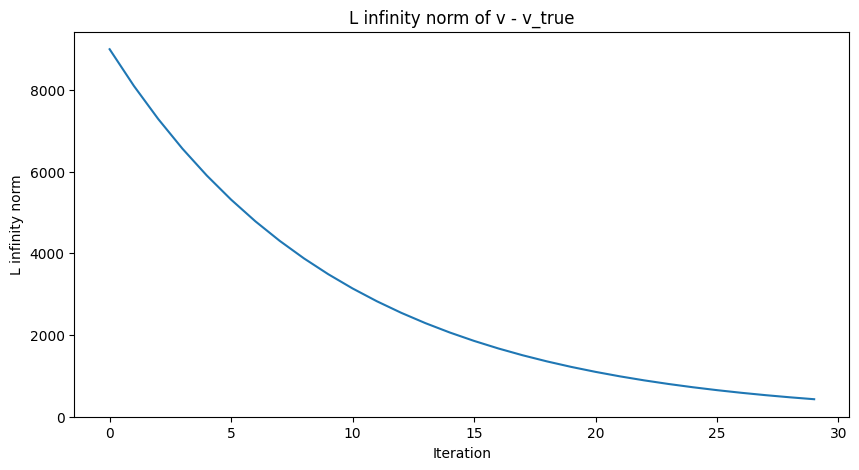

 12%|█▎        | 1/8 [00:00<00:01,  6.46it/s]

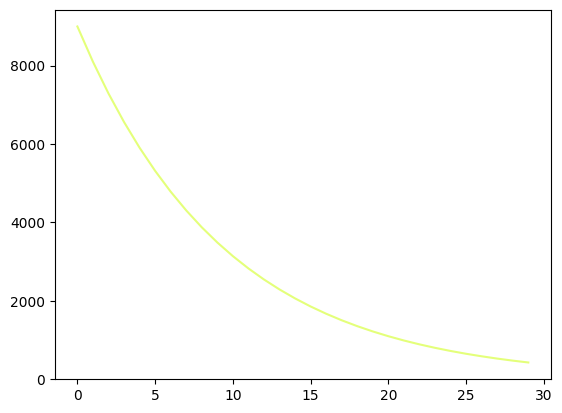

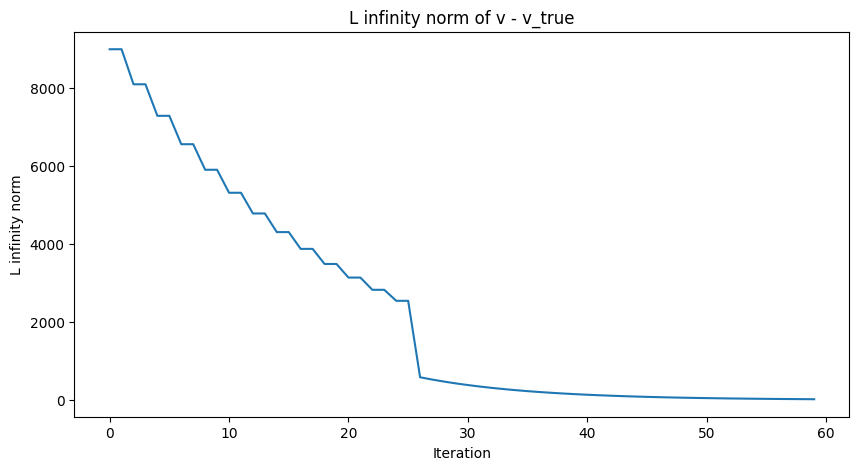

 25%|██▌       | 2/8 [00:00<00:01,  4.46it/s]

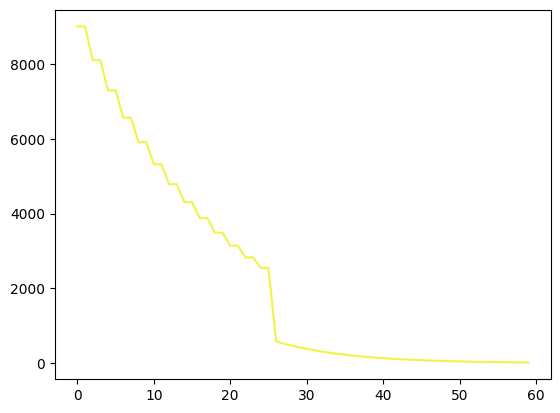

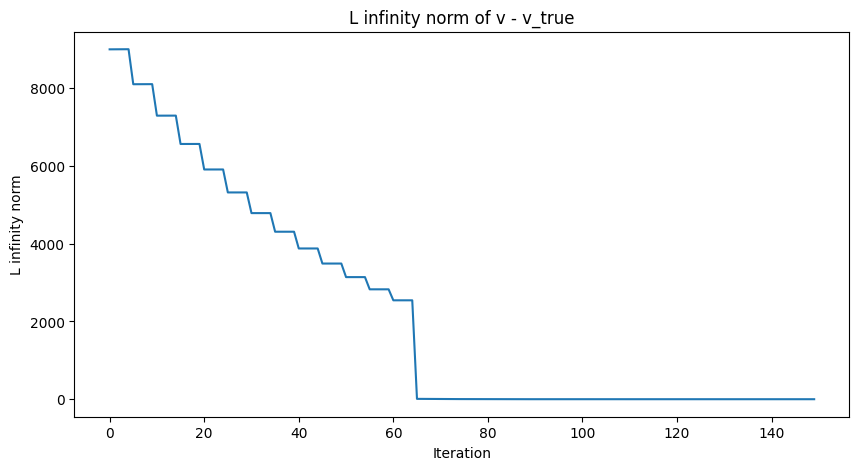

 38%|███▊      | 3/8 [00:00<00:01,  2.87it/s]

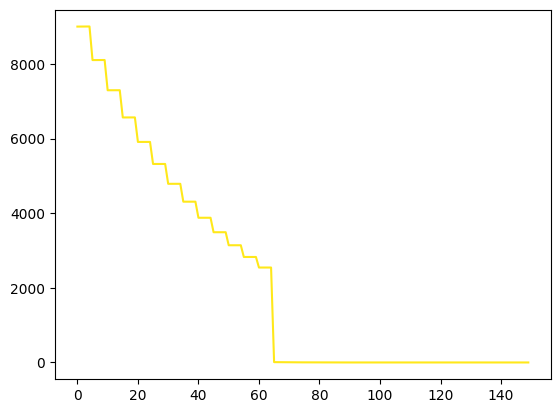

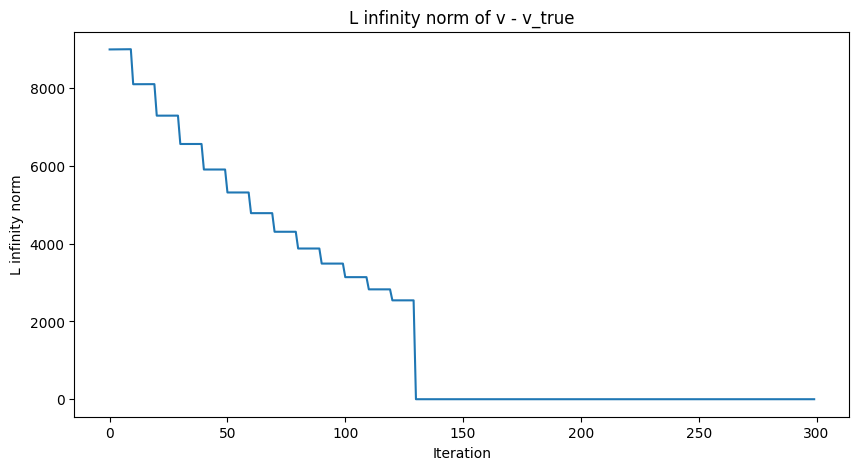

 50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

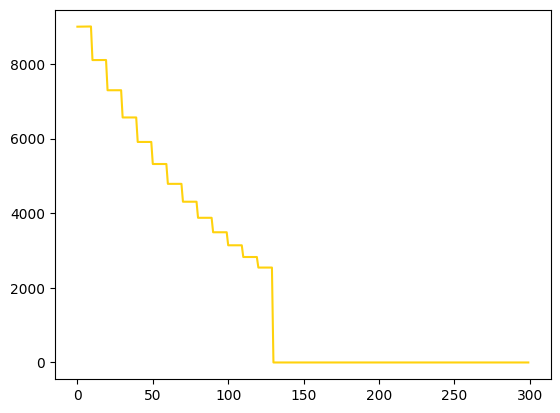

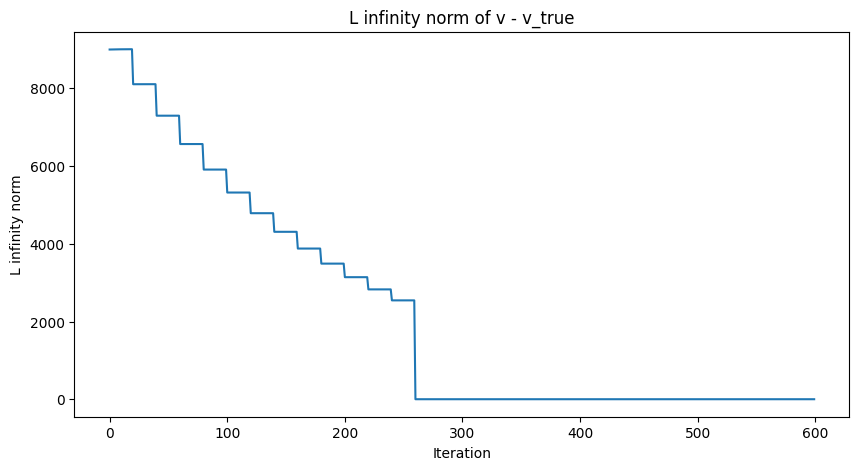

 62%|██████▎   | 5/8 [00:01<00:01,  2.87it/s]

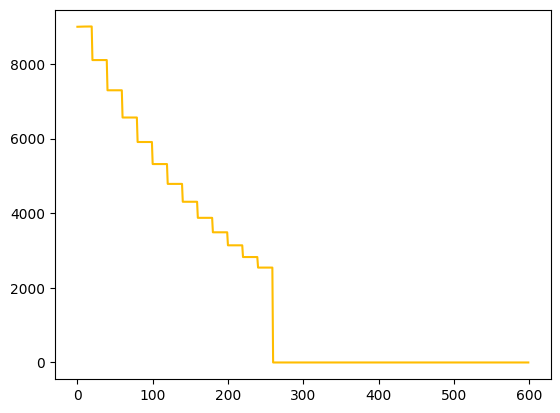

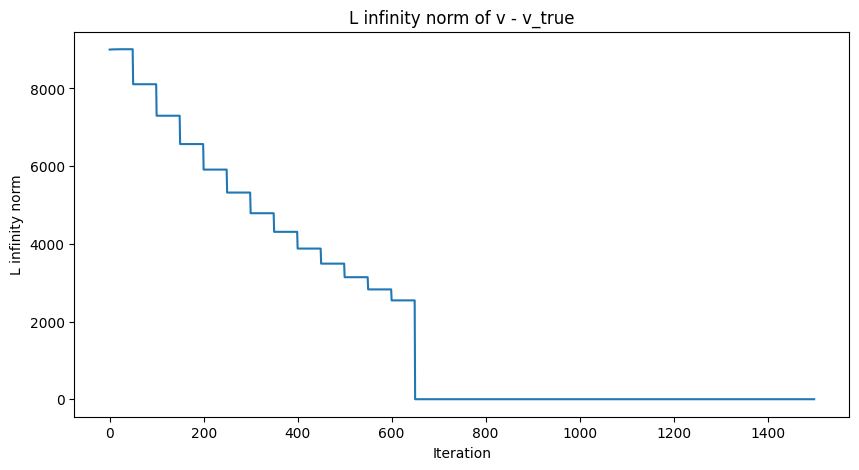

 75%|███████▌  | 6/8 [00:02<00:00,  2.81it/s]

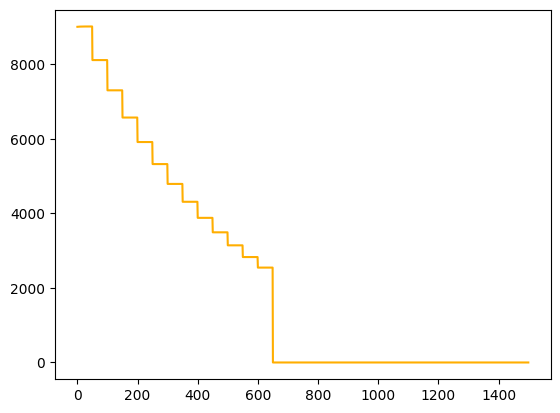

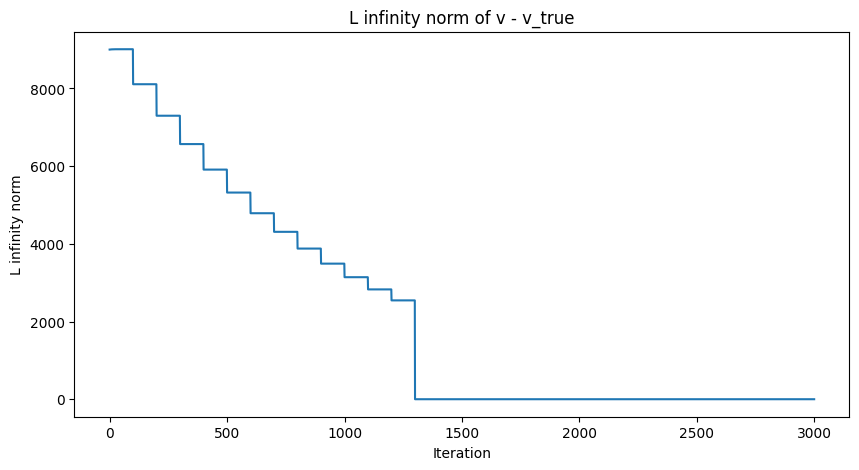

 88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]

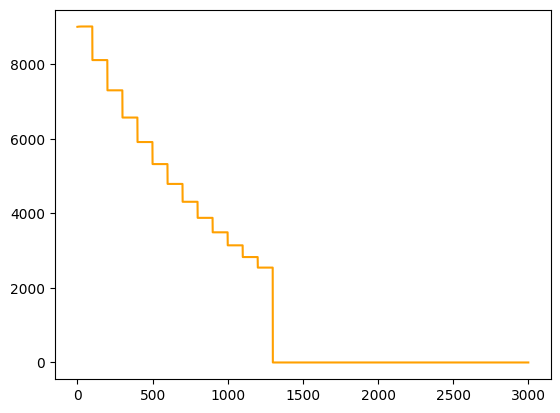

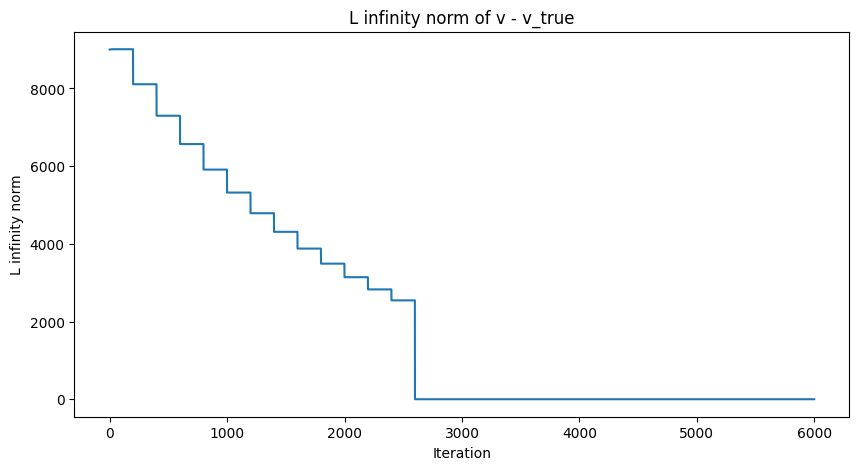

100%|██████████| 8/8 [00:03<00:00,  2.49it/s]


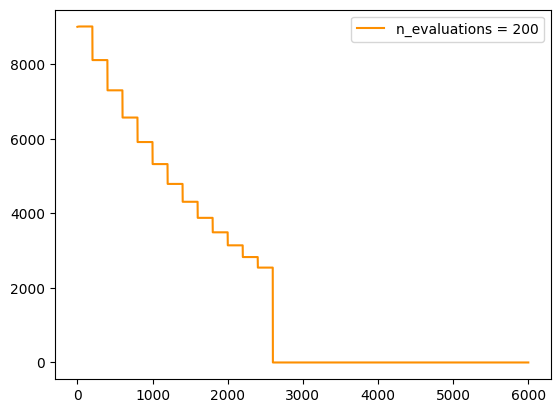

In [42]:
from tqdm import tqdm
s, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
n_actions, n_states = R.shape
_, v_true = VI(R, P, 100, 0.9)
cmap = plt.get_cmap('Wistia')
points = [1, 2, 5, 10, 20, 50, 100, 200]
plt.figure()
for k, i in enumerate(tqdm(points)):
  _, norm = Modified_PI(R, P, n_iter=30, n_evaluations=i, gamma=0.9, v_true=v_true)
  plt.plot(norm,  color=cmap(k/len(points)), label="n_evaluations = %i" % i )
plt.legend()

# Policy iteration (PI)
Policy iteration is the limit of modified policy iteration as the number of times $m$ the the policy evaluation operator is appplied goes to infinity: $m → \infty$.

Policy iteration starts from $v_0 = 0$ and iterates:
- Set $\pi_k$ to be the greedy policy with respect to $v_k$ (**policy improvement** or **greedifying**)
- Compute $v_{k+1} = v^{\pi_k} = (I - \gamma P^{\pi_k})^{-1} r^{\pi_k}$ (**policy evaluation** )
where
$$
P^{\pi_k}(s, s') = \sum_a P_a(s, s') \pi(a | s)
$$
and
$$
r^{\pi_k}(s) = \sum_a r_a(s) \pi (a | s).
$$

PI performs the iterations above $K$ times starting from $v_0 = 0$ and returns $\pi_{K+1}$.

**Task** Implement exact policy iteration

In [45]:
def PI(R, P, n_iter, gamma, v_true=None):
  """
  Implement policy iteration by initializing the value function v to zero
  and repeating n_iter times:
    - Return the greedy policy pi with respect to v
    - Set v to the fixed point of the policy evaluation operator of pi
  Record the l infinity norm between v and v_true after policy evaluation step

  Parameters
  ----------
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  n_iter: int
   Number of iterations in the main loop
  gamma: float
    Discounting parameter (between 0 and 1)
  v_true: np array of size n_states or None
   The true value function

  Return
  ------
  pi: np array of size n_states
    Policy returned by PI
  errors: np array of size n_iter (Optional)
    errors[i] is the l infinity norm of v_true - v at iteration i.
    Only returned if v_true is not None
  """
  n_actions, n_states = R.shape
  v = np.zeros(n_states)
  norms = []
  for _ in range(n_iter):
    pi = greedy_policy_value(v, R, P, gamma)
    Ppi = np.zeros((n_states, n_states))
    Rpi = np.zeros(n_states)
    for s in range(n_states):
      a = int(pi[s])
      Ppi[s, :] = P[a, s, :]
      Rpi[s] = R[a, s]
    v = np.linalg.inv(np.eye(n_states) - gamma * Ppi).dot(Rpi)
    if v_true is not None:
      norms.append(np.max(np.abs(v - v_true)))
  if v_true is not None:
    return greedy_policy_value(v, R, P, gamma), np.array(norms)
  else:
    return greedy_policy_value(v, R, P, gamma)

**Task** Plot performance across iterations in function of `n_evaluations` (same plot we did before) adding exact policy iteration

[1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 200]


<Figure size 640x480 with 0 Axes>

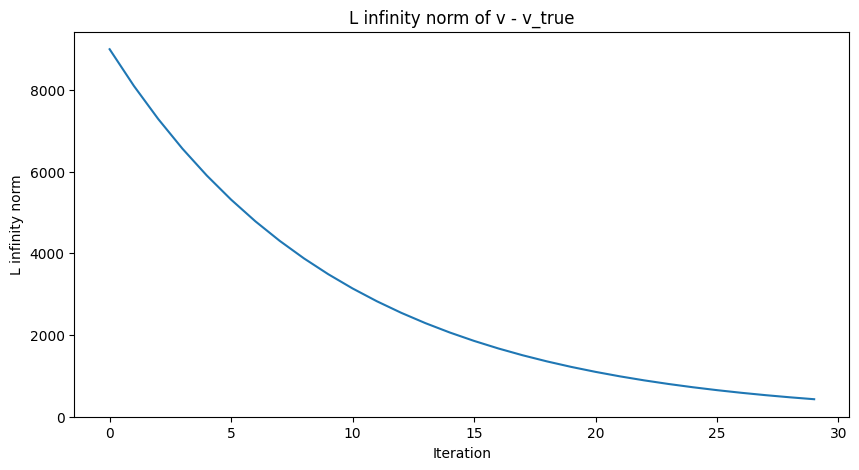

0it [00:00, ?it/s]

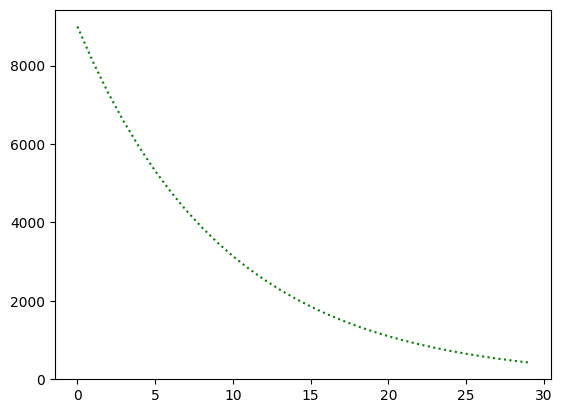

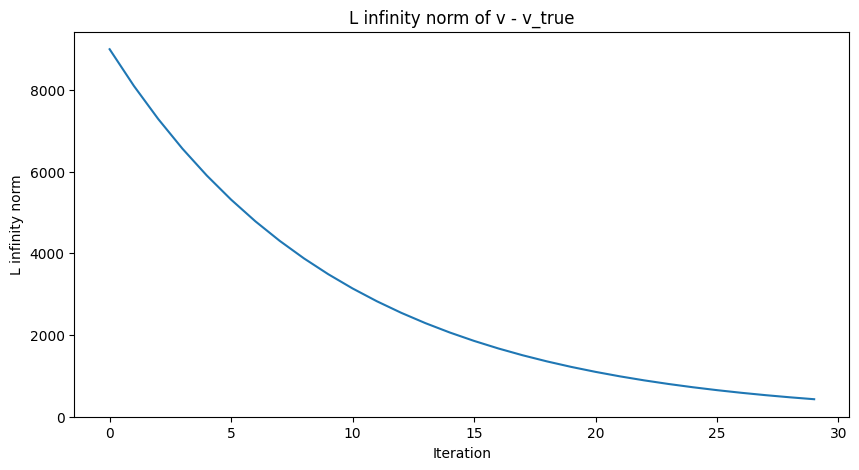

1it [00:00,  4.24it/s]

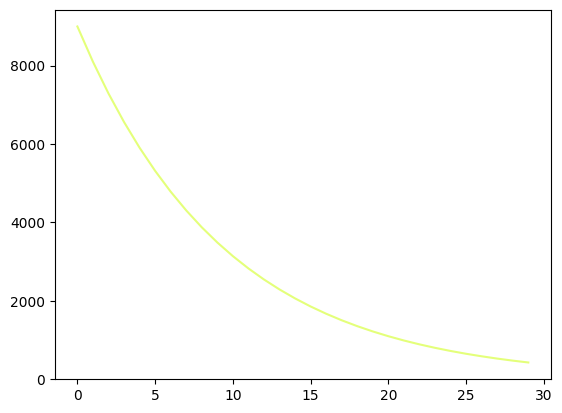

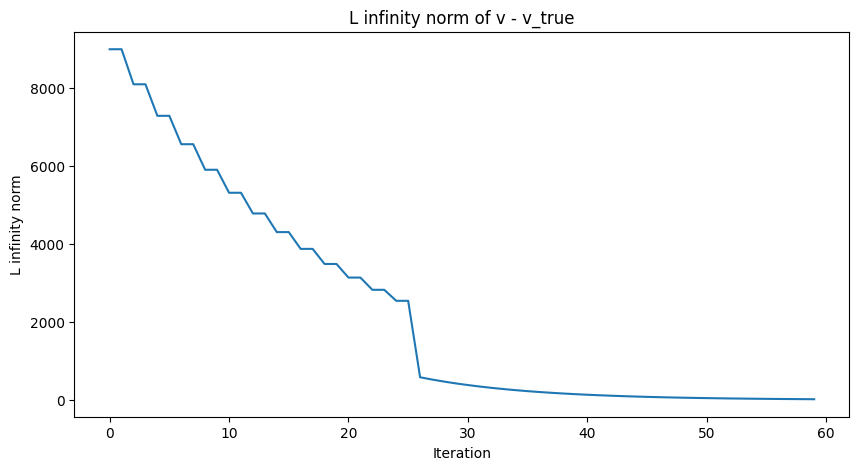

2it [00:00,  2.86it/s]

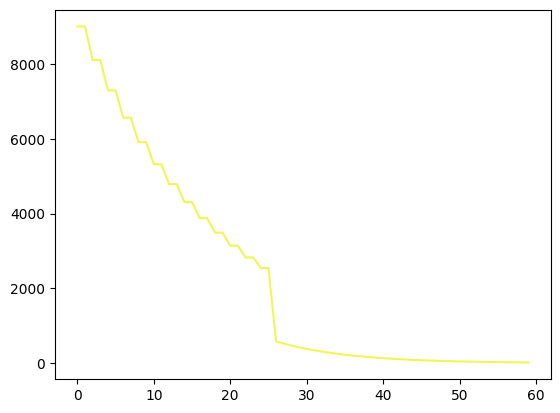

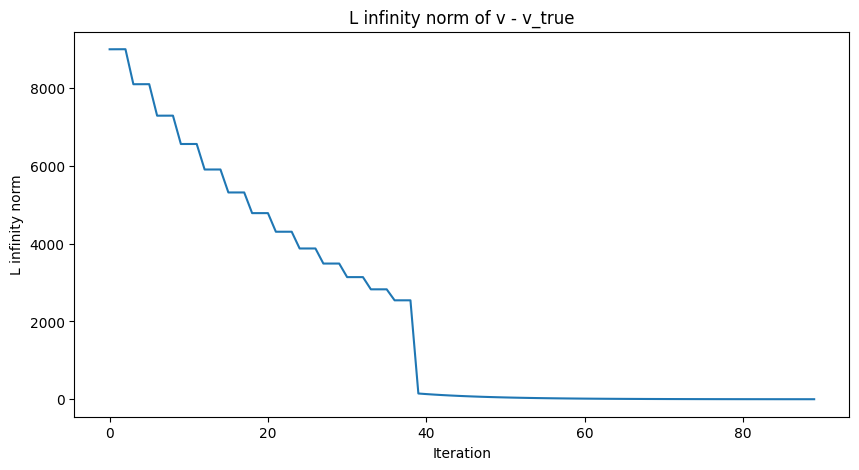

3it [00:00,  3.42it/s]

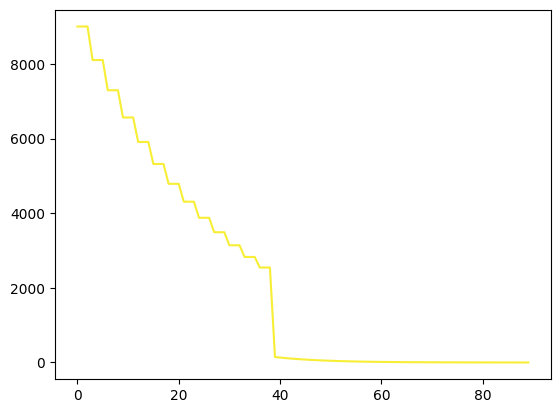

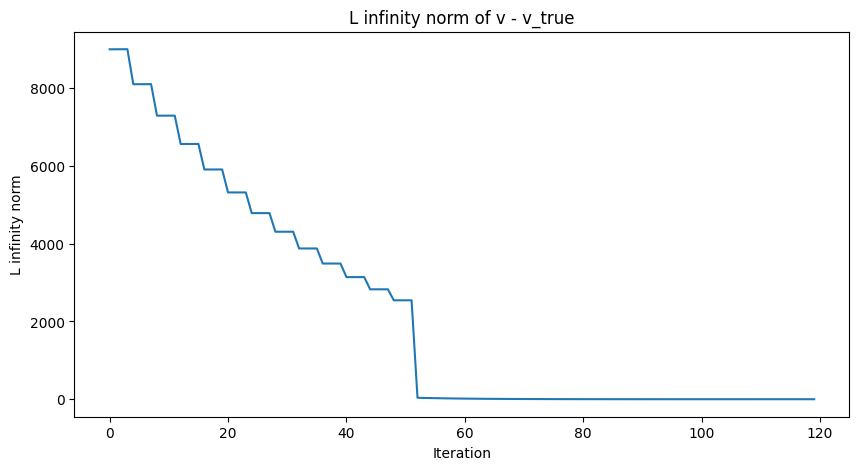

4it [00:01,  3.54it/s]

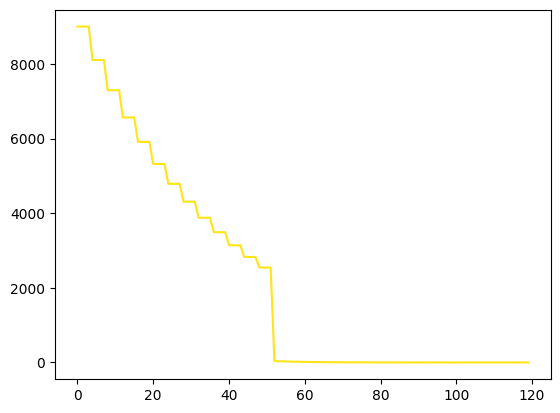

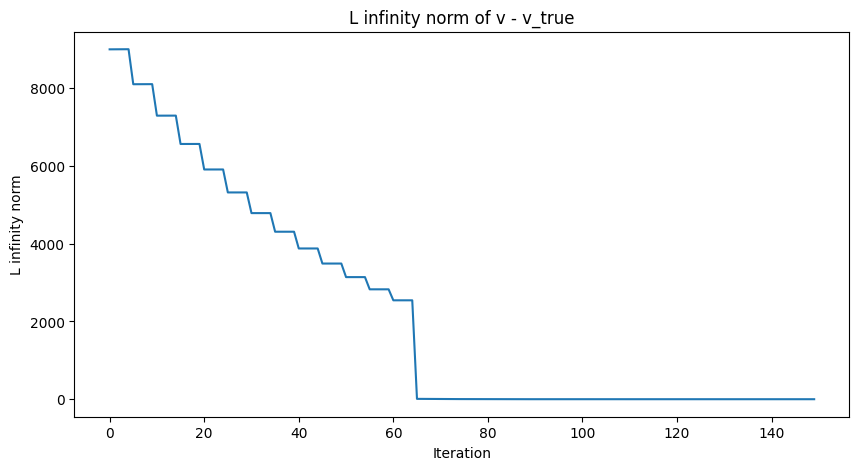

5it [00:01,  3.00it/s]

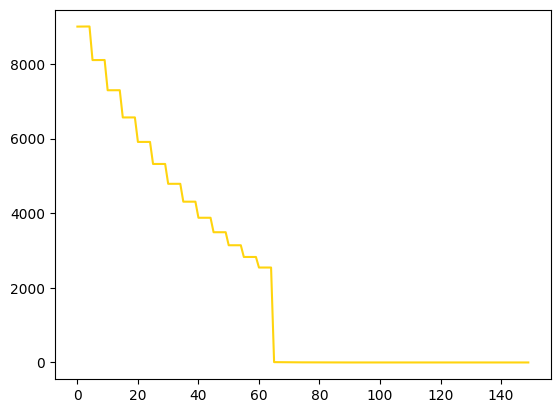

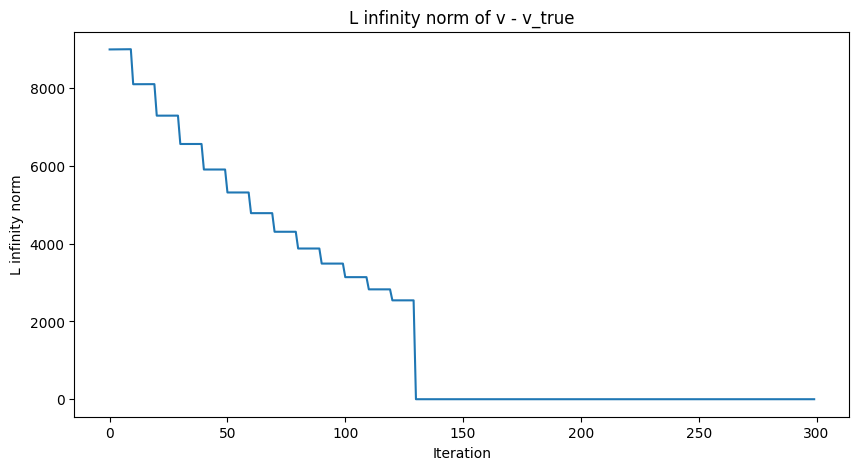

6it [00:01,  3.18it/s]

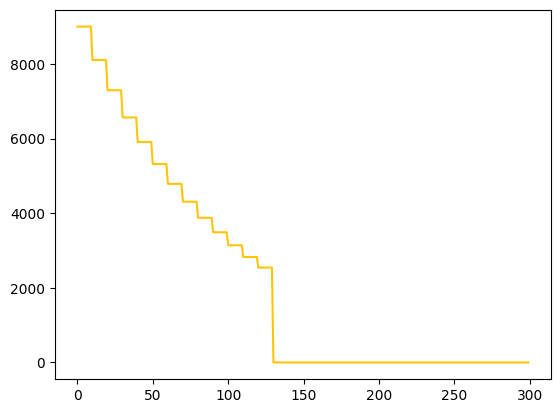

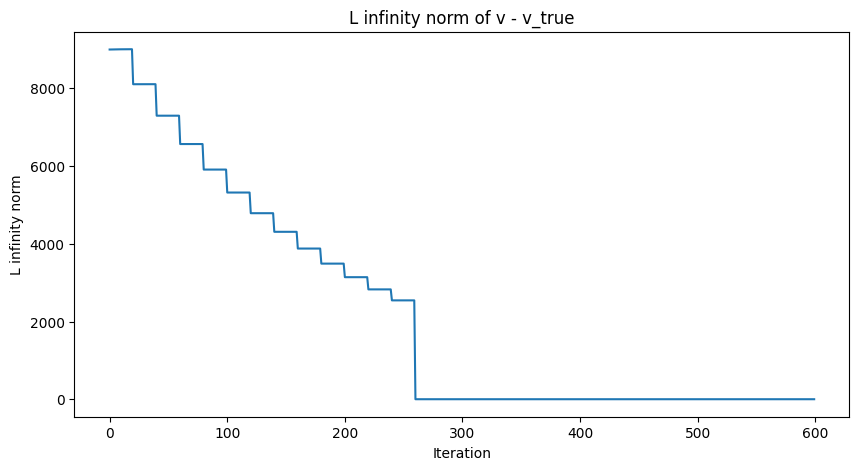

7it [00:02,  3.23it/s]

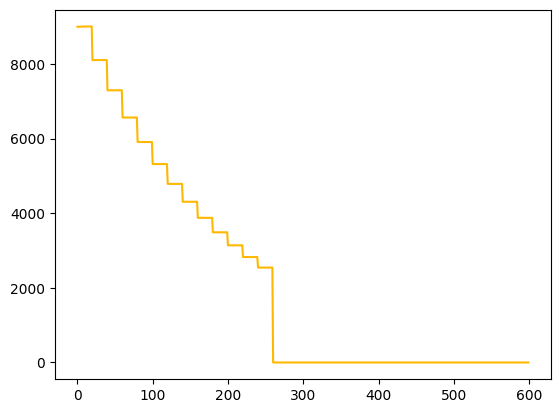

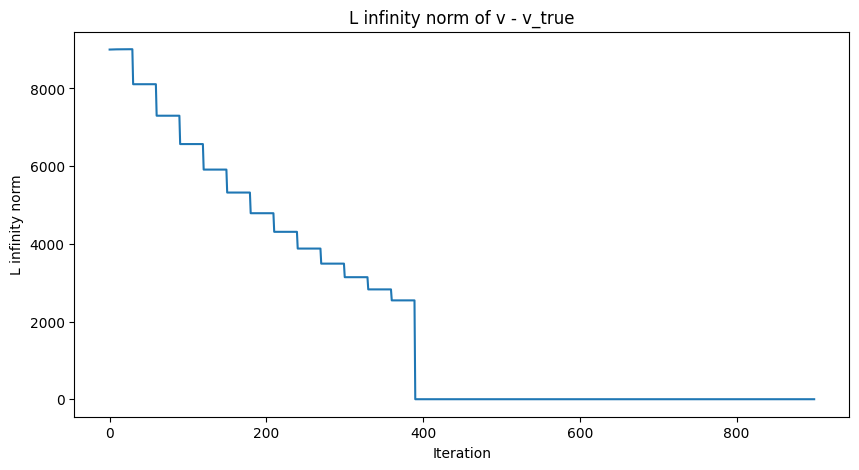

8it [00:02,  3.26it/s]

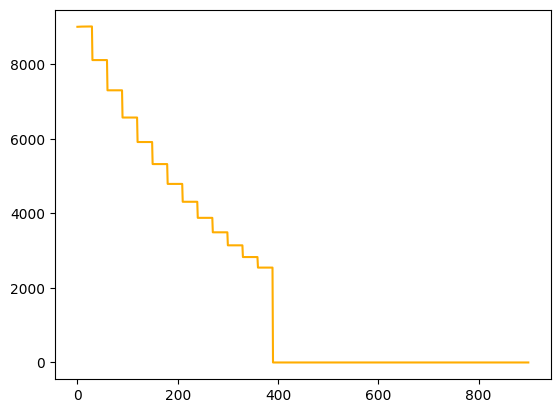

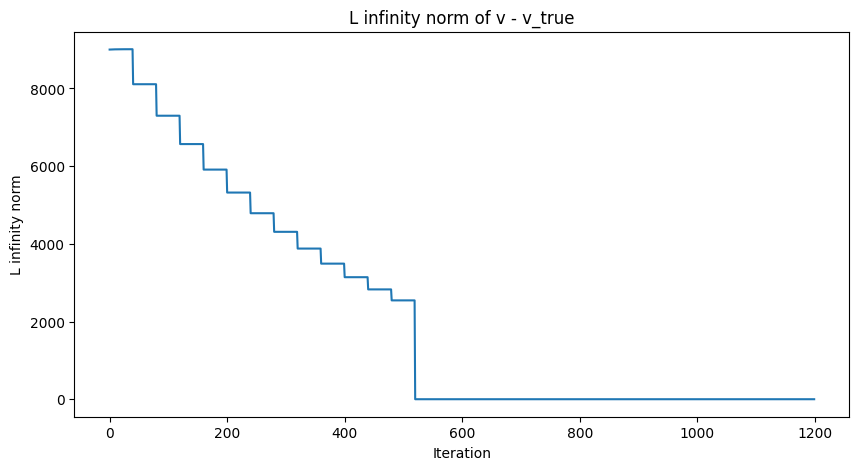

9it [00:02,  3.13it/s]

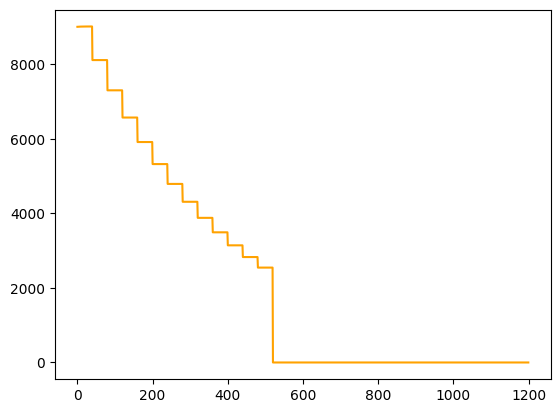

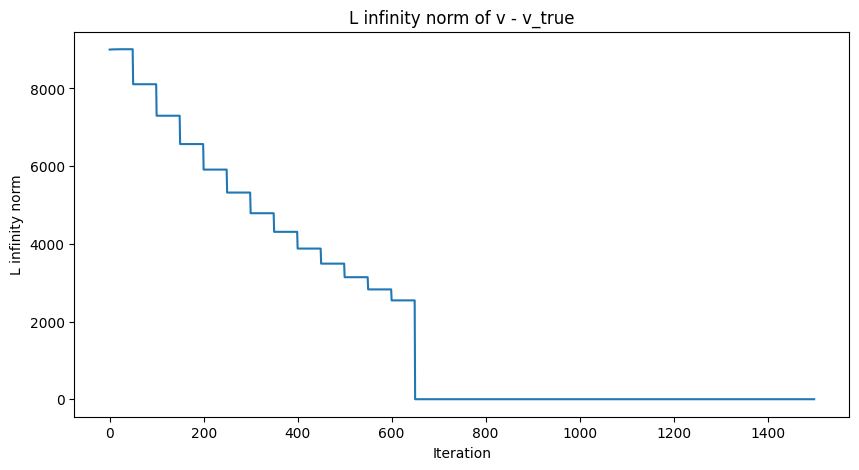

10it [00:03,  3.00it/s]

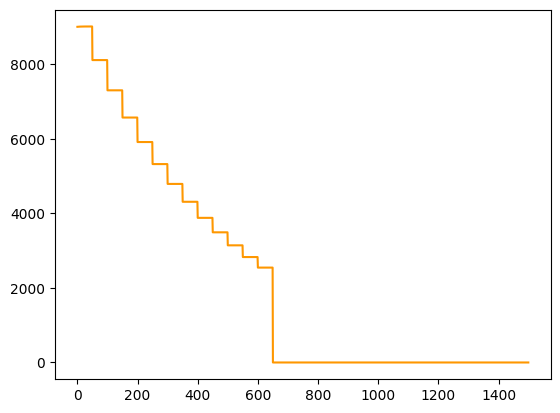

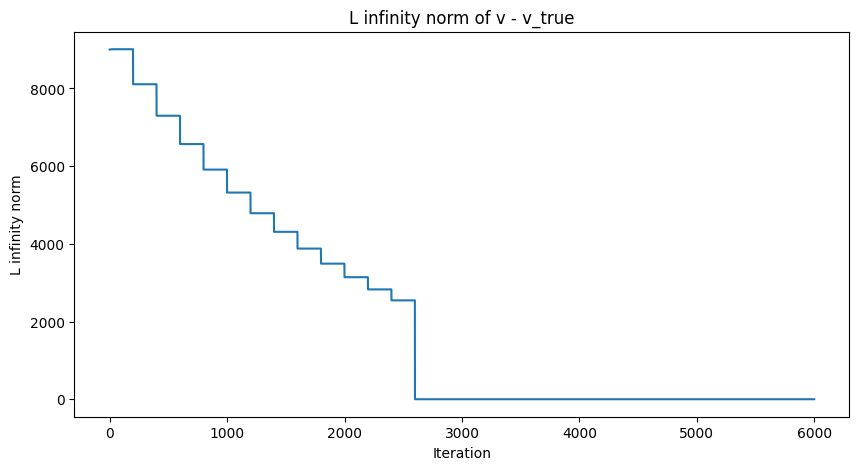

11it [00:04,  2.71it/s]


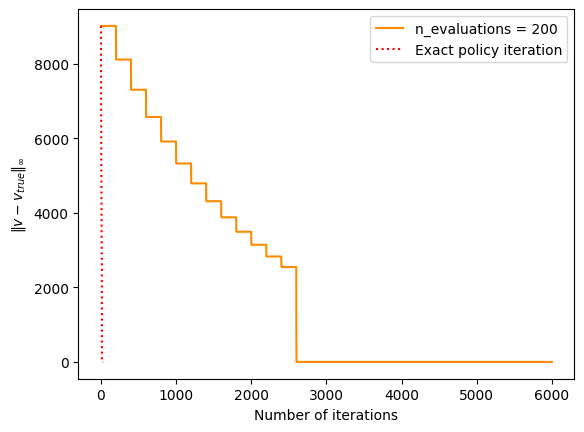

In [46]:
from tqdm import tqdm
s, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
_, v_true = VI(R, P, 100, 0.9)
cmap = plt.get_cmap('Wistia')
points = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 200]
print(points)
plt.figure()
_, norm = Modified_PI(R, P, n_iter=30, n_evaluations=1, gamma=0.9, v_true=v_true)
plt.plot(norm, color="green",  label="Exact value iteration", linestyle="dotted")
for en, i in tqdm(enumerate(points)):
  _, norm = Modified_PI(R, P, n_iter=30, n_evaluations=i, gamma=0.9, v_true=v_true)
  plt.plot(norm,  color=cmap(en/len(points)), label="n_evaluations = %i" % i )
_, norm = PI(R, P, n_iter=30, gamma=0.9, v_true=v_true)
plt.ylabel("$\|v - v_{true}\|_\infty$")
plt.xlabel("Number of iterations")
plt.plot(norm, color="red",  label="Exact policy iteration", linestyle="dotted")
plt.legend()

# Modified policy iteration using state-action value functions

An other view on modified policy iteration is given by considering state-action value function instead of state value function.

The state-action value function associated to policy $\pi$ is denoted $q^{\pi}$.

It is defined by:
\begin{align*}
q^{\pi}(s, a) &= r_a(s) + \gamma \sum_{s'} P_a(s, s') v^{\pi}(s').
\end{align*}

The optimal state-action value function is given by
$$
q^*(s, a) = \max_{\pi} q^\pi(s, a).
$$
It is clear from the results on state value function that:
$$
q^*(s, a) = r_a(s) + \gamma \sum_{s'} P_a(s, s') v^*(s').
$$
the maximum being reached by the memory-less deterministic policy that is greedy with respect to $v^*$. We then have
$$
\pi^*(s) = \text{argmax}_{a} q^*(s, a).
$$

From the definition, it can be seen that $v^{\pi}(s) = \sum_a q^{\pi}(s, a) \pi(a | s)$ and $v^* = \max_a q^*(s, a)$.

It therefore holds that:
$$
q^{\pi} = T^{\pi} q^{\pi}
$$
where $T^{\pi}$ is redefined to be:
$$
T^{\pi} q (s, a) =  r_a(s) + \gamma \sum_{s'} P_a(s, s') \sum_{a'} \pi(a' | s') q(s', a'),
$$
and
$$
q^* = T q^*
$$
where $T$ is redefined to be:
$$
T q (s, a) = r_a(s) + \gamma \sum_{s'} P_a(s, s') \max_{a'} q(s', a').
$$

Then we can redefine value iteration, modified policy iteration and policy iteration.

**Value iteration for state-action value function**

Initialize $q_0 = 0$ and repeat $K$ times
* $q_{k+1} = T q_k$

and return the policy $\pi(s) = \text{argmax}_a q_{K+1}(s, a)$.

**Modified policy iteration for state-action value function**

Initialize $q_0 = 0$ and repeat $K$ times
* Compute $\pi_k$ greedy with respect to $q_k$
* Set $q_{k+1} = (T^{\pi_k})^m q_k$

and return the policy $\pi(s) = \text{argmax}_a q_{K+1}(s, a)$.

**Policy iteration for state-action value function**

Initialize $q_0 = 0$ and repeat $K$ times
* Compute $\pi_k$ greedy with respect to $q_k$
* Set $q_{k+1} =  q^{\pi_k}$
and return the policy $\pi(s) = \text{argmax}_a q_{K+1}(s, a)$.

*Note* The closed form for $q^{\pi}$ can be computed thanks to the closed form for $v^{\pi}$.



**Task** Implement state-action value function modified policy iteration

In [47]:
def QMPI(R, P, n_iter, n_evaluations, gamma, v_true=None):
  """
  Implement state-action value function modified policy iteration.
  Initialize Q to zero
  Repeat n_iter times
  - Compute pi the policy greedy with respect to Q
  - Apply n_evaluations times the bellman policy evaluation operator to Q

  Parameters
  ----------
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  n_iter: int
   Number of iterations in the main loop
  n_evaluations: int
   Number of times the policy evaluation operator is applied per iteration
  gamma: float
    Discounting parameter (between 0 and 1)
  v_true: np array of size n_states or None
   The true value function

  Return
  ------
  pi: np array of size n_states
    Policy returned by PI
  errors: np array of size n_iter (Optional)
    errors[i] is the l infinity norm of v_true - v at iteration i.
    Only returned if v_true is not None
  """
  n_actions, n_states = R.shape
  Q = np.zeros((n_states, n_actions))
  errors = []
  for _ in range(n_iter):
    pi = np.argmax(Q, axis=1)
    for _ in range(n_evaluations):
      Qpi = [ Q[s, pi[s]] for s in range(n_states)]
      for s in range(n_states):
        Q[s, :] = R[:, s] +  gamma * P[:, s, :].dot(Qpi)
    if v_true is not None:
      errors.append(np.max(np.abs(np.max(Q, axis=1) - v_true)))
  if v_true is not None:
    return np.argmax(Q, axis=1), errors
  else:
    return np.argmax(Q)

**Task** Implement a function that computes the state-action value function of  a deterministic policy using a closed form expression. Then, use it to perform exact policy iteration using state-action value function.

In [48]:
def q_pi(R, P, gamma, pi):
  """
  Compute the state-action value function of pi (in closed form)

  Parameters
  ----------
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  gamma: float
    Discounting parameter (between 0 and 1)
  pi: np array of size n_states
    Policy to evaluate
  Return
  ------
  q_pi: np array of size n_states, n_actions
    State action value of pi
  """
  n_actions, n_states = R.shape
  Rpi = np.zeros(n_states)
  Ppi = np.zeros((n_states, n_states))
  I = np.eye(n_states)
  for s in range(n_states):
    Rpi[s] = R[pi[s], s]
    Ppi[s] = P[pi[s], s, :]
  v_pi = np.linalg.inv(I - gamma * Ppi).dot(Rpi)
  qpi = np.zeros((n_states, n_actions))
  for s in range(n_states):
    for a in range(n_actions):
      qpi[s, a] = R[a, s] + gamma * P[a, s, :].dot(v_pi)
  return qpi


def QPI(R, P, n_iter, gamma, v_true=None):
  """
  Implement exact policy iteration using state-action value function.
  Initialize Q to zero
  Repeat n_iter
  - Compute pi the policy greedy with respect to Q
  - Set Q to the state-action value function of pi

  Parameters
  ----------
  R: np array of shape (n_actions, n_states)
   R[a, s] return the reward obtained after playing action a in state s
  P: np array of shape (n_actions, n_states, n_states)
   P[a, s, s2] returns the probability of transitionning to s2 if playing action a in state s
  n_iter: int
   Number of iterations in the main loop
  gamma: float
    Discounting parameter (between 0 and 1)
  v_true: np array of size n_states or None
   The true value function

  Return
  ------
  pi: np array of size n_states
    Policy returned by PI
  errors: np array of size n_iter (Optional)
    errors[i] is the l infinity norm of v_true - v at iteration i.
    Only returned if v_true is not None
  """
  n_actions, n_states = R.shape
  q = np.zeros((n_states, n_actions))
  errors = []
  for _ in range(n_iter):
    pi = np.argmax(q, axis=1)
    q = q_pi(R, P, gamma, pi)
    errors.append(np.max(np.abs(np.max(q, axis=1) - v_true)))
  return pi, errors

**Task** Compare (exact) value iteration, policy iteration (with state-action value function) with modified policy iterations (with state-action value function)

[1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 200]


11it [00:05,  1.97it/s]


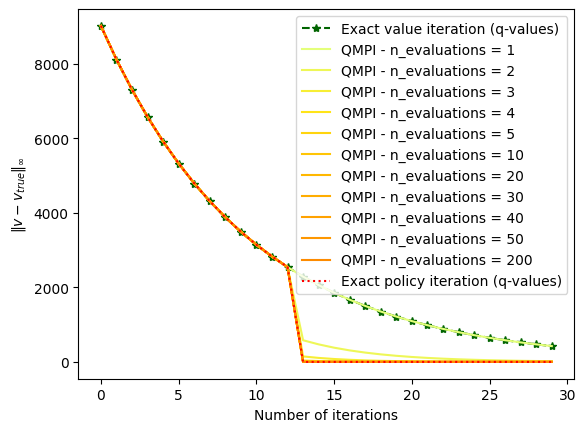

In [49]:
from tqdm import tqdm
s, _ = env.reset()
R, P = make_reward_function_transition_matrix(env)
_, v_true = VI(R, P, 100, 0.9)
cmap = plt.get_cmap('Wistia')
points = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 200]
print(points)
plt.figure()
_, norm = QMPI(R, P, n_iter=30, n_evaluations=1, gamma=0.9, v_true=v_true)
plt.plot(norm, color="darkgreen",  label="Exact value iteration (q-values)", linestyle="dashed", marker="*")
for en, i in tqdm(enumerate(points)):
  _, norm = QMPI(R, P, n_iter=30, n_evaluations=i, gamma=0.9, v_true=v_true)
  plt.plot(norm,  color=cmap(en/len(points)), label="QMPI - n_evaluations = %i" % i )
_, norm = QPI(R, P, n_iter=30, gamma=0.9, v_true=v_true)
plt.ylabel("$\|v - v_{true}\|_\infty$")
plt.xlabel("Number of iterations")
plt.plot(norm, color="red",  label="Exact policy iteration (q-values)", linestyle="dotted")
plt.legend()